1. done
The student should preprocess the images by resizing them to a common size, converting them to grayscale or RGB, and normalizing the pixel values.
2. done needs to run
Feature Extraction using SIFT and Bag of Words: The student should extract features from the images
using Scale-Invariant Feature Transform (SIFT) (or similar approaches, SIFT, FAST, DENSE SIFT) and Bag of Words (BoW) representation and train a
traditional classifier (e.g., Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN)) to classify
them.
3. done needs to run  
Convolutional Neural Networks: The student should train a convolutional neural network (CNN) on the preprocessed
images to classify them into different categories. The student should experiment with a custom neural architecture.

6.
Model Evaluation: The student should evaluate the performance of the models using metrics such as accuracy,
precision, recall, and F1-score.


# **0 - setup 🫙**


## **0.0** - install

In [1]:
!pip install wandb
!pip install lightning
!pip install torchmetrics
!pip install opencv-python opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **0.1** - import

In [2]:
#utilities
import glob
import os
from tqdm.auto import tqdm
import wandb
import joblib
import time
from PIL import Image
import concurrent
import random
import shutil

# data science
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import sklearn.cluster
import sklearn.naive_bayes
import sklearn.svm
import sklearn.neighbors
import sklearn.ensemble
import sklearn.metrics

#computer vision
import cv2

# torch
import torch
import torchvision
import torchvision.transforms.v2 as transforms
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


# lightning
import lightning as L


## **0.2** - general setup

In [3]:
# set up the gpu if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#clean the working directory
!rm -rf sample_data

# **1 - source ⚗️**

## **1.1** - data preprocessing, feature extraction, ssl augmentation

use pytorch dataset and data loaders as always, but now wrap everything inside a lightning datamodule for better organisation

### 1.1.1 - datasets

In [4]:
#default dataset code from pytorch documentation
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file: str = "./", img_dir: str = "./", transform = None, target_transform = None):
        self.img_labels = pd.read_csv(annotations_file, header = None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torchvision.io.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def get_path(self,idx):
        return os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])


In [5]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file: str = "./", feat_dir: str = "./"):
        self.labels = pd.read_csv(annotations_file, header = None)
        self.feat_dir = feat_dir

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feat_path = os.path.join(self.feat_dir, self.labels.iloc[idx, 0].replace('.jpg', '.npy'))
        feat = np.load(feat_path, allow_pickle=True)
        label = self.labels.iloc[idx, 1]

        return feat, label


### 1.1.2 - main datamodule

In [6]:
class MainDataModule(L.LightningDataModule):
    def __init__(self, data_urls: dict, transform = None, batch_size: int = 512):
        super().__init__()
        self.data_urls = data_urls
        self.transform = transform
        self.batch_size = batch_size

    # empty prepare data to speed up training
    def prepare_data(self):
        pass

    # custom prepare data function to download data once and for all
    def prepare_data_mine(self):
        #download annotations
        os.system(f"wget {self.data_urls['annotations']}")
        #download training images
        os.system(f"wget {self.data_urls['training_images']}")
        #download validation images
        os.system(f"wget {self.data_urls['validation_images']}")

        # Extract tar files
        os.system("tar -xf annot.tar")
        os.system("tar -xf train.tar")
        os.system("tar -xf val.tar")

        # Clean up the working directory
        os.remove("annot.tar")
        os.remove("train.tar")
        os.remove("val.tar")
        os.remove("test_info.csv")

        # Rename directories and files
        if os.path.exists("test_set"):
            shutil.rmtree("test_set")
        os.rename("val_set", "test_set")
        os.rename("val_info.csv", "test_info.csv")
        os.rename("train_info.csv", "train_val_info.csv")

        #Extract the validation set
        os.makedirs("val_set", exist_ok=True)

        train_ratio = 0.8

        with open("train_val_info.csv", 'r') as f:
            annotations = f.readlines()


        random.shuffle(annotations)

        split_index = int(len(annotations) * train_ratio)

        train_annotations = annotations[:split_index]
        val_annotations = annotations[split_index:]

        with open("train_info.csv", 'w') as f:
            f.writelines(train_annotations)

        with open("val_info.csv", 'w') as f:
            f.writelines(val_annotations)

        os.remove("train_val_info.csv")

        val_image_names = [line.split(',')[0] for line in val_annotations]

        for val_image in val_image_names:
            image_path = os.path.join("train_set", val_image)

            if os.path.exists(image_path):
                shutil.move(image_path, os.path.join("val_set", val_image))


    # the setup method is called to create the image dataset and can be called multiple times
    def setup(self, stage: str = "train"):

        # make assignments (val/train/test split)
        self.train = ImagesDataset(annotations_file = "train_info.csv", img_dir = "train_set", transform = self.transform)
        self.val = ImagesDataset(annotations_file = "val_info.csv", img_dir = "val_set", transform = self.transform)
        self.test = ImagesDataset(annotations_file = "test_info.csv",img_dir = "test_set", transform = self.transform)

        #define the label to class hashmap
        self.label_to_class = {}

        with open("class_list.txt", 'r') as file:
            for line in file:
                label, class_name = line.strip().split()
                self.label_to_class[label] = class_name


        self.train_labels = pd.read_csv("train_info.csv", header = None).iloc[:, 1].values
        print(f"train shape: {self.train_labels.shape}")

        self.val_labels = pd.read_csv("val_info.csv", header = None).iloc[:, 1].values
        print(f"val shape: {self.val_labels.shape}")

        self.test_labels = pd.read_csv("test_info.csv", header = None).iloc[:, 1].values
        print(f"test shape: {self.test_labels.shape}")


    # dataloader methods
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train, batch_size = self.batch_size, shuffle=True, num_workers=os.cpu_count())

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val, batch_size = self.batch_size, shuffle = False, num_workers=os.cpu_count())

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test, batch_size = self.batch_size, shuffle = False, num_workers=os.cpu_count())



    # custom method to visualise some images as a sanity check
    def visualise_some_images(self, n: int = 20):

        #imagenet normalisation
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])

        images, labels = next(iter(self.train_dataloader()))
        image, labels =  images[:n], labels[:n]
        n_rows = max(int((n-1)/10)+1,2)
        fig, axes = plt.subplots(n_rows, 10, figsize=(50, n_rows * 5) )


        for i in range(n):
            image = images[i]
            label = labels[i]
            image = image.mul(std.unsqueeze(1).unsqueeze(2))
            image = image.add(mean.unsqueeze(1).unsqueeze(2))
            image = image.clamp(0, 1)
            image = image.permute(1, 2, 0).numpy()

            axes[int(i/10),i%10].imshow(image)
            axes[int(i/10),i%10].set_title(self.label_to_class[str(label.item())])
            axes[int(i/10),i%10].axis('off')

        plt.show()


    #custom module to extract sift features from the image datasets
    def extract_sift_features(self):

        !mkdir train_features val_features test_features
        !mkdir train_features/descriptors train_features/keypoints
        !mkdir val_features/descriptors val_features/keypoints
        !mkdir test_features/descriptors test_features/keypoints

        sift = cv2.SIFT_create()

        for dataset, folder in [(self.train, "train_features"), (self.val, "val_features"), (self.test, "test_features")]:

            for i in tqdm(range(len(dataset))):

                image, label = dataset[i]

                image_path = dataset.get_path(i)

                image = image.permute(1, 2, 0).numpy()  # Change to (H, W, C)
                image = (image * 255).astype(np.uint8)

                gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                ## descriptors computation
                kp, des = sift.detectAndCompute(gray_image, None)

                ## save everything

                # descriptors
                file_name = os.path.splitext(os.path.basename(image_path))[0]
                np.save(os.path.join(folder, "descriptors", file_name + ".npy") , des)

                # keypoints
                kp = np.array([[
                    kp_.pt[0],  # x-coordinate
                    kp_.pt[1],  # y-coordinate
                    kp_.size,   # size
                    kp_.angle,  # angle
                    kp_.response,  # response
                    kp_.octave,  # octave
                    kp_.class_id   # class_id
                ] for kp_ in kp])

                np.save(os.path.join(folder, "keypoints", file_name + ".npy") , kp)

    # keep a dataset of sift features for easier acces by subsequent modules
    def setup_sift_datasets(self):

        # des
        self.train_sift_des = FeaturesDataset(annotations_file = "train_info.csv", feat_dir = "train_features/descriptors")
        self.val_sift_des = FeaturesDataset(annotations_file = "val_info.csv", feat_dir = "val_features/descriptors")
        self.test_sift_des = FeaturesDataset(annotations_file = "test_info.csv", feat_dir = "test_features/descriptors")


        # kp
        self.train_sift_kp = FeaturesDataset(annotations_file = "train_info.csv", feat_dir = "train_features/keypoints")
        self.val_sift_kp = FeaturesDataset(annotations_file = "val_info.csv", feat_dir = "val_features/keypoints")
        self.test_sift_kp = FeaturesDataset(annotations_file = "test_info.csv", feat_dir = "test_features/keypoints")


    #custom method to extract the bow features from images
    def extract_bow_features(self, vocabulary_size: int = 1000, batch_size = 10000):

        '''
        this method will extract the bow descriptions for the train, val and
        test sets, it requires sift features, so both extract sift_features and
        setup_sift_datasets must have been called before it
        '''


        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters = vocabulary_size, batch_size = batch_size)


        #get all descriptors

        for dataset in [self.train_sift_des]:

            n_batches = int(len(dataset) / batch_size) + 1

            for batch in tqdm(range(n_batches)):

                des = []

                for i in tqdm(range(batch_size)):

                    idx = batch * batch_size + i

                    if idx >= len(dataset):
                        continue

                    descriptor = dataset[idx][0]

                    if len(descriptor.shape) == 2:
                        des.append(descriptor)

                des = np.concatenate(des, axis=0)

                kmeans.partial_fit(des)



        #build the bow matrices
        for dataset, bow_name in [(self.train_sift_des, "train_bow"), (self.val_sift_des, "val_bow"), (self.test_sift_des, "test_bow")]:

            current_bow = np.zeros((len(dataset), vocabulary_size))

            for i in tqdm(range(len(dataset))):

                descriptor, label = dataset[i]

                if len(descriptor.shape) == 2:

                    predictions = kmeans.predict(descriptor)

                    current_bow[i,:] = np.bincount(predictions, minlength = vocabulary_size)

                else:
                    print(f"anomaly at index {i}")
                    current_bow[i,:] = np.zeros(vocabulary_size)


            setattr(self, bow_name, current_bow)

        os.makedirs("bow_features", exist_ok=True)
        np.save("bow_features/train_bow.npy", self.train_bow)
        np.save("bow_features/val_bow.npy", self.val_bow)
        np.save("bow_features/test_bow.npy", self.test_bow)

    # custom method to download the bow features from the server
    def prepare_bow_features(self, bow_url, file_name):
        os.system(f"wget {bow_url}")
        os.system(f"tar -xf {file_name}")

    # custom method to setup the bow features by considering whatever version is on disk
    def setup_bow_features(self):
        self.train_bow = np.load("bow_features/train_bow.npy")
        self.val_bow = np.load("bow_features/val_bow.npy")
        self.test_bow = np.load("bow_features/test_bow.npy")




##**1.2** - traditional models

Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN), neural networks, adaboost

stacking



I don't need source code, the models are implemented in sk_learn

## **1.3** - deep learning with supervised learning

### 1.2.1 Resnet

In [7]:
#first module to increase the channels and bring the dimensionality to the blocks' one
class Funnel(nn.Module):
    def __init__(self, in_channels:int = 3, out_channels:int = 64):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 7 , stride = 1, padding = 3)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        return x

In [8]:
m = Funnel()
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
              ReLU-2         [-1, 64, 256, 256]               0
         MaxPool2d-3         [-1, 64, 128, 128]               0
Total params: 9,472
Trainable params: 9,472
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 72.00
Params size (MB): 0.04
Estimated Total Size (MB): 72.79
----------------------------------------------------------------


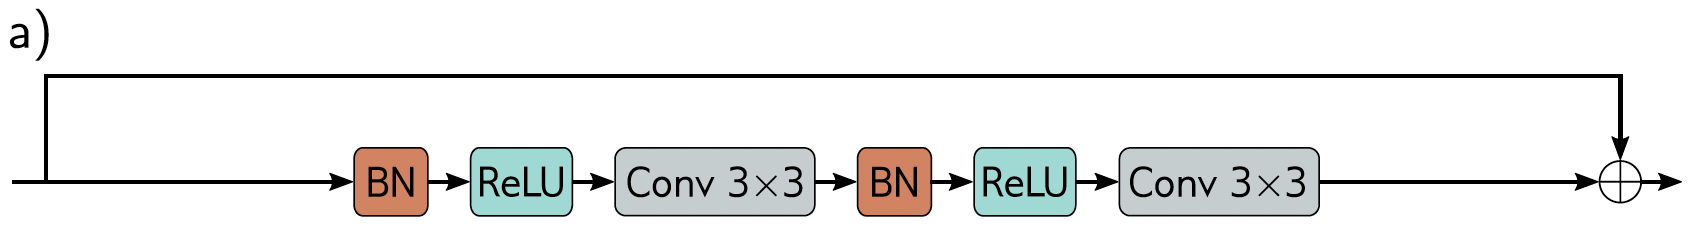

In [9]:
#implementation of the normal resnet block in the figure above
class NormalBlock(nn.Module):
    def __init__(self, in_channels:int = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 3 , stride = 1, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv2 = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, kernel_size = 3 , stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(num_features = in_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv2(x)
        return x

In [10]:
m = NormalBlock()
m.to(device)
torchsummary.summary(m, input_size = (64,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1         [-1, 64, 256, 256]             128
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          36,928
Total params: 74,112
Trainable params: 74,112
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 16.00
Forward/backward pass size (MB): 192.00
Params size (MB): 0.28
Estimated Total Size (MB): 208.28
----------------------------------------------------------------


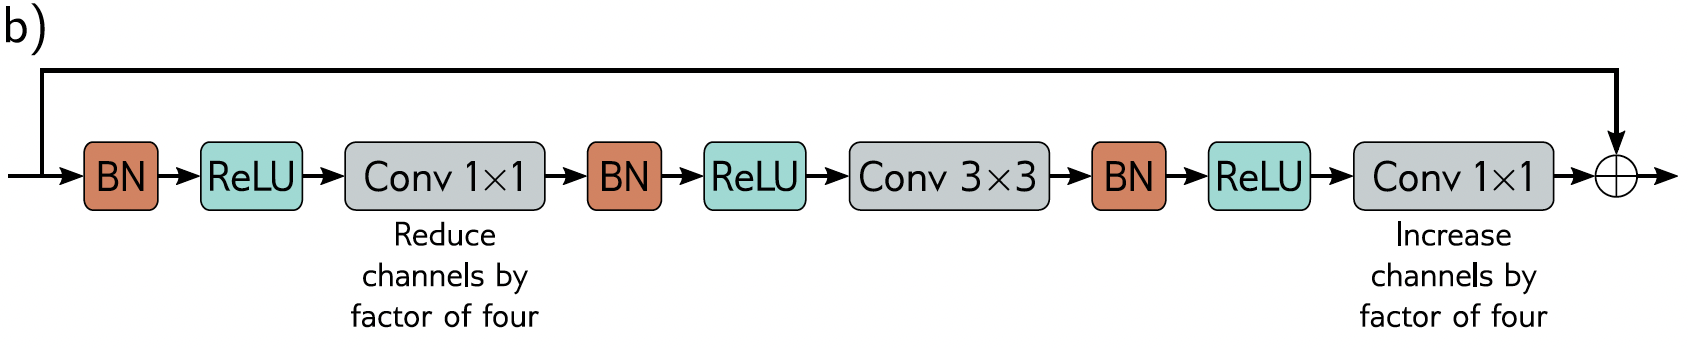

In [11]:
#implementation of the bottleneck resnet block in the figure above
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels:int = 32):
        super().__init__()
        self.intermediate_channels = int(in_channels/4)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = self.intermediate_channels, kernel_size = 1 , stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels = self.intermediate_channels, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = self.intermediate_channels, out_channels = in_channels, kernel_size = 1 , stride = 1, padding = 0)
        self.batch_norm1 = nn.BatchNorm2d(num_features = in_channels)
        self.batch_norm2 = nn.BatchNorm2d(num_features = self.intermediate_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.activation(x)
        x = self.conv3(x)
        return x




In [12]:
m = BottleneckBlock()
m.to(device)
torchsummary.summary(m, input_size = (32,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1         [-1, 32, 256, 256]              64
              ReLU-2         [-1, 32, 256, 256]               0
            Conv2d-3          [-1, 8, 256, 256]             264
       BatchNorm2d-4          [-1, 8, 256, 256]              16
              ReLU-5          [-1, 8, 256, 256]               0
            Conv2d-6          [-1, 8, 256, 256]             584
       BatchNorm2d-7          [-1, 8, 256, 256]              16
              ReLU-8          [-1, 8, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]             288
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 8.00
Forward/backward pass size (MB): 72.00
Params size (MB): 0.00
Estimated Total Size (MB): 80.00
---------------------------------------------

In [13]:
#final prediction module that flattens the image features and predict classes
class PredictorHead(nn.Module):
    def __init__(self,in_dimensions: tuple[int, int, int] = (64,128,128), n_classes = 251):
        super().__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        flattened_dim = int(in_dimensions[0]*in_dimensions[1]*in_dimensions[2])
        self.layer1 = nn.Linear(flattened_dim, n_classes)
        self.layer2 = nn.Linear(n_classes, n_classes)

    def forward(self,x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x




In [14]:
m = PredictorHead(in_dimensions = (16,16,16))
m.to(device)
torchsummary.summary(m, input_size = (16,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 4096]               0
            Linear-2                  [-1, 251]       1,028,347
              ReLU-3                  [-1, 251]               0
           Dropout-4                  [-1, 251]               0
            Linear-5                  [-1, 251]          63,252
Total params: 1,091,599
Trainable params: 1,091,599
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 4.16
Estimated Total Size (MB): 4.22
----------------------------------------------------------------


In [15]:
# final resnet architecture composed of the modules described above
class ResNet(nn.Module):
    def __init__(self, in_channels = 3, int_channels = 32, n_blocks = 20, n_pools = 2, block_type = "normal",  n_classes = 251):

        '''
        n_blocks/n_pools should be an integer, if it isnt the constructor will round it
        '''

        super().__init__()

        self.funnel = Funnel(in_channels = in_channels, out_channels = int_channels)

        self.n_pools = n_pools
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)


        self.body = nn.ModuleList([])
        blocks_per_pool = int(n_blocks/n_pools)

        if block_type == "bottleneck":
            for i in range(n_pools):

                if i >= 4:
                    self.body.append(nn.Conv2d(in_channels = int_channels, out_channels = int_channels * 4, kernel_size = 1 , stride = 1))
                    int_channels = int_channels * 4

                for j in range(blocks_per_pool):
                    self.body.append(BottleneckBlock(in_channels = int_channels))

                self.body.append(self.pool)


        if block_type == "normal":
            for i in range(n_pools):

                for j in range(blocks_per_pool):
                    self.body.append(NormalBlock(in_channels = int_channels))

                self.body.append(self.pool)



        final_dimension = int(128/(2**n_pools))

        self.predictor = PredictorHead(in_dimensions = (int_channels,final_dimension,final_dimension),n_classes = n_classes)

    def forward(self,x):

        x = self.funnel(x)

        for block in self.body:
            if isinstance(block, nn.MaxPool2d):
                x = block(x)

            elif isinstance(block, nn.Conv2d):
                x = block(x)

            else:
                x = x + block(x)

        x = self.predictor(x)

        return x


In [16]:
m = ResNet(in_channels = 3, int_channels = 32, n_blocks = 30, n_pools = 5, block_type = "bottleneck",  n_classes = 251)
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Funnel-4         [-1, 32, 128, 128]               0
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7          [-1, 8, 128, 128]             264
       BatchNorm2d-8          [-1, 8, 128, 128]              16
              ReLU-9          [-1, 8, 128, 128]               0
           Conv2d-10          [-1, 8, 128, 128]             584
      BatchNorm2d-11          [-1, 8, 128, 128]              16
             ReLU-12          [-1, 8, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]             288
  BottleneckBlock-14         [-1, 32, 1

### 1.2.2 - Simple Cnn


In [17]:
# simple, funeel shaped, convolutional neural network

class SimpleCnn(nn.Module):
    def __init__(self,  n_classes = 251, activation = 'relu'):

        '''
        '''

        super().__init__()

        activation_class = {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU()
        }

        self.activation = activation_class[activation]

        #256
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7 , stride = 1, padding = 0)
        #250
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3 , stride = 1, padding = 0)
        #248
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #124
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #122
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #120
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #60
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #58
        self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3 , stride = 1, padding = 0)
        #56
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #28
        self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3 , stride = 1, padding = 0)
        #26
        self.conv8 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3 , stride = 1, padding = 0)
        #24
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        #12
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)
        self.layer1 = nn.Linear(12*12*16, n_classes)
        self.layer2 = nn.Linear(n_classes, n_classes)



    def forward(self,x):

        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.activation(x)
        x = self.conv6(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.conv7(x)
        x = self.activation(x)
        x = self.conv8(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)

        return x

In [18]:
m = SimpleCnn()
m.to(device)
torchsummary.summary(m, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 250, 250]           2,368
              ReLU-2         [-1, 16, 250, 250]               0
            Conv2d-3         [-1, 32, 248, 248]           4,640
              ReLU-4         [-1, 32, 248, 248]               0
         MaxPool2d-5         [-1, 32, 124, 124]               0
              ReLU-6         [-1, 32, 124, 124]               0
            Conv2d-7         [-1, 64, 122, 122]          18,496
              ReLU-8         [-1, 64, 122, 122]               0
            Conv2d-9         [-1, 64, 120, 120]          36,928
             ReLU-10         [-1, 64, 120, 120]               0
        MaxPool2d-11           [-1, 64, 60, 60]               0
           Conv2d-12           [-1, 64, 58, 58]          36,928
             ReLU-13           [-1, 64, 58, 58]               0
           Conv2d-14           [-1, 64,

### 1.2.3 - Final classification system

In [19]:
# as mandated by lightning guidelines, wrap everything in a lightning module for easier training ecc.
class CnnImageClassification(L.LightningModule):

    def __init__(self, model, loss_module, optimizer_name: str , optimizer_hparams):
        super().__init__()
        self.model = model
        self.loss_module = loss_module
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        if self.optimizer_name == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), **self.optimizer_hparams)
        elif self.optimizer_name == "SGD":
            optimizer = torch.optim.SGD(self.parameters(), **self.optimizer_hparams)

        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_module(y_hat, y)

        acc = (y_hat.argmax(dim=-1) == y).float().mean()

        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x).argmax(dim=-1)
        acc = (y == preds).float().mean()

        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def on_test_start(self):
        self.test_preds = []
        self.test_targets = []

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self.model(x).argmax(dim=-1)

        self.test_preds.append(preds)
        self.test_targets.append(y)

        acc = (y == preds).float().mean()
        self.log("test_acc_batch", acc, prog_bar=True)

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds, dim=0)
        targets = torch.cat(self.test_targets, dim=0)

        acc = (preds == targets).float().mean()
        precision = torchmetrics.functional.precision(preds, targets, task='multiclass', num_classes=251, average='weighted')
        recall = torchmetrics.functional.recall(preds, targets, task='multiclass', num_classes=251, average='weighted')
        f1 = torchmetrics.functional.f1_score(preds, targets, task='multiclass', num_classes=251, average='weighted')

        self.log("test_acc", acc)
        self.log("test_precision", precision)
        self.log("test_recall", recall)
        self.log("test_f1", f1)

        print(f"Test Accuracy: {acc:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")







## **1.5** - model evaluation

Accuracy	[0, 1]	Proportion of correct predictions
Precision	[0, 1]	Fraction of true positives out of predicted positives
Recall	[0, 1]	Fraction of true positives out of actual positives
F1-Score	[0, 1]	Harmonic mean of precision and recall
AUC-ROC	[0, 1]	Area under the ROC curve
AUC-PR

In [20]:
# function to train and validate models with a single run, prints the time taken too
def test_model( vocabulary_size = 100, download = False,  model_class = None, data_module = None, model_params = None):

    if download:
        bow_url = f"https://jig.blob.core.windows.net/jigcontainer/bow_features_{vocabulary_size}.tar"
        file_name = f"bow_features_{vocabulary_size}.tar"
        my_data.prepare_bow_features(bow_url, file_name)
        my_data.setup_bow_features()



    start = time.time()

    X_train = data_module.train_bow
    y_train = data_module.train_labels
    X_test =  data_module.test_bow
    y_test =  data_module.test_labels

    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)

    model = model_class(**model_params)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred, average='micro')
    recall = sklearn.metrics.recall_score(y_test, y_pred, average='micro')
    f1 = sklearn.metrics.f1_score(y_test, y_pred, average='micro')

    end = time.time()

    print(f"time taken: {end - start}")

    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1: {f1}")

# **2 - script 🔥**

## **2.1** - data

### 2.1.1 - data download and preparation

In [21]:
data_urls = {
    "annotations": "https://food-x.s3.amazonaws.com/annot.tar",
    "training_images": "https://food-x.s3.amazonaws.com/train.tar",
    "validation_images": "https://food-x.s3.amazonaws.com/val.tar"
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Normalisation
])



my_data = MainDataModule(data_urls = data_urls, transform = transform, batch_size = 192)


In [22]:
#download the data and format the folders
my_data.prepare_data_mine()

In [23]:
# setup the datasets
my_data.setup()

train shape: (94780,)
val shape: (23695,)
test shape: (11994,)


### 2.1.2 - visualisation

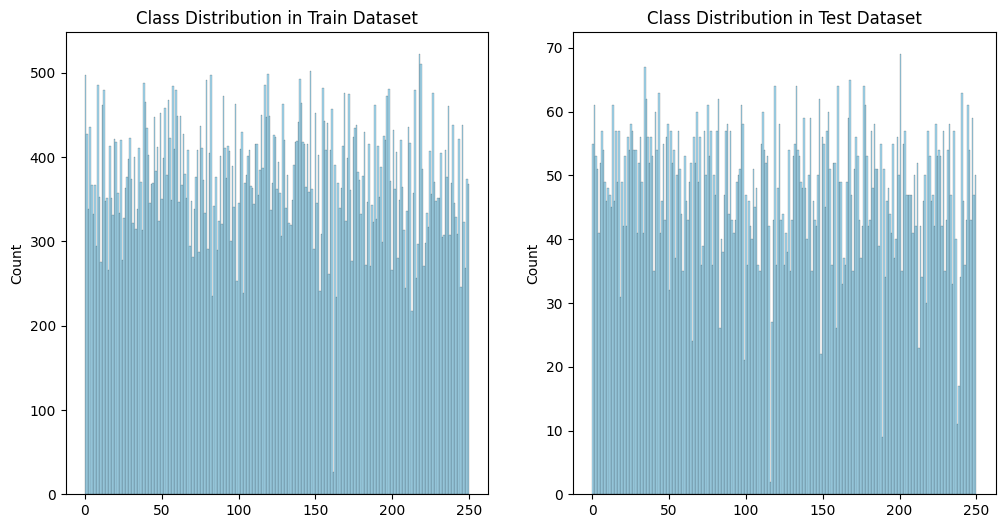

In [ ]:
#visualise the class distribution in the datasets
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(my_data.train_labels,
    kde=False,
    bins=len(np.unique(my_data.train_labels)),
    color='skyblue',
    ax=axes[0]
)

axes[0].set_title('Class Distribution in Train Dataset')


sns.histplot(my_data.val_labels,
    kde=False,
    bins=len(np.unique(my_data.val_labels)),
    color='skyblue',
    ax=axes[1]
)

axes[1].set_title('Class Distribution in Val Dataset')


sns.histplot(my_data.test_labels,
    kde=False,
    bins=len(np.unique(my_data.test_labels)),
    color='skyblue',
    ax=axes[2]
)

axes[2].set_title('Class Distribution in Test Dataset')

plt.show()

del fig, axes




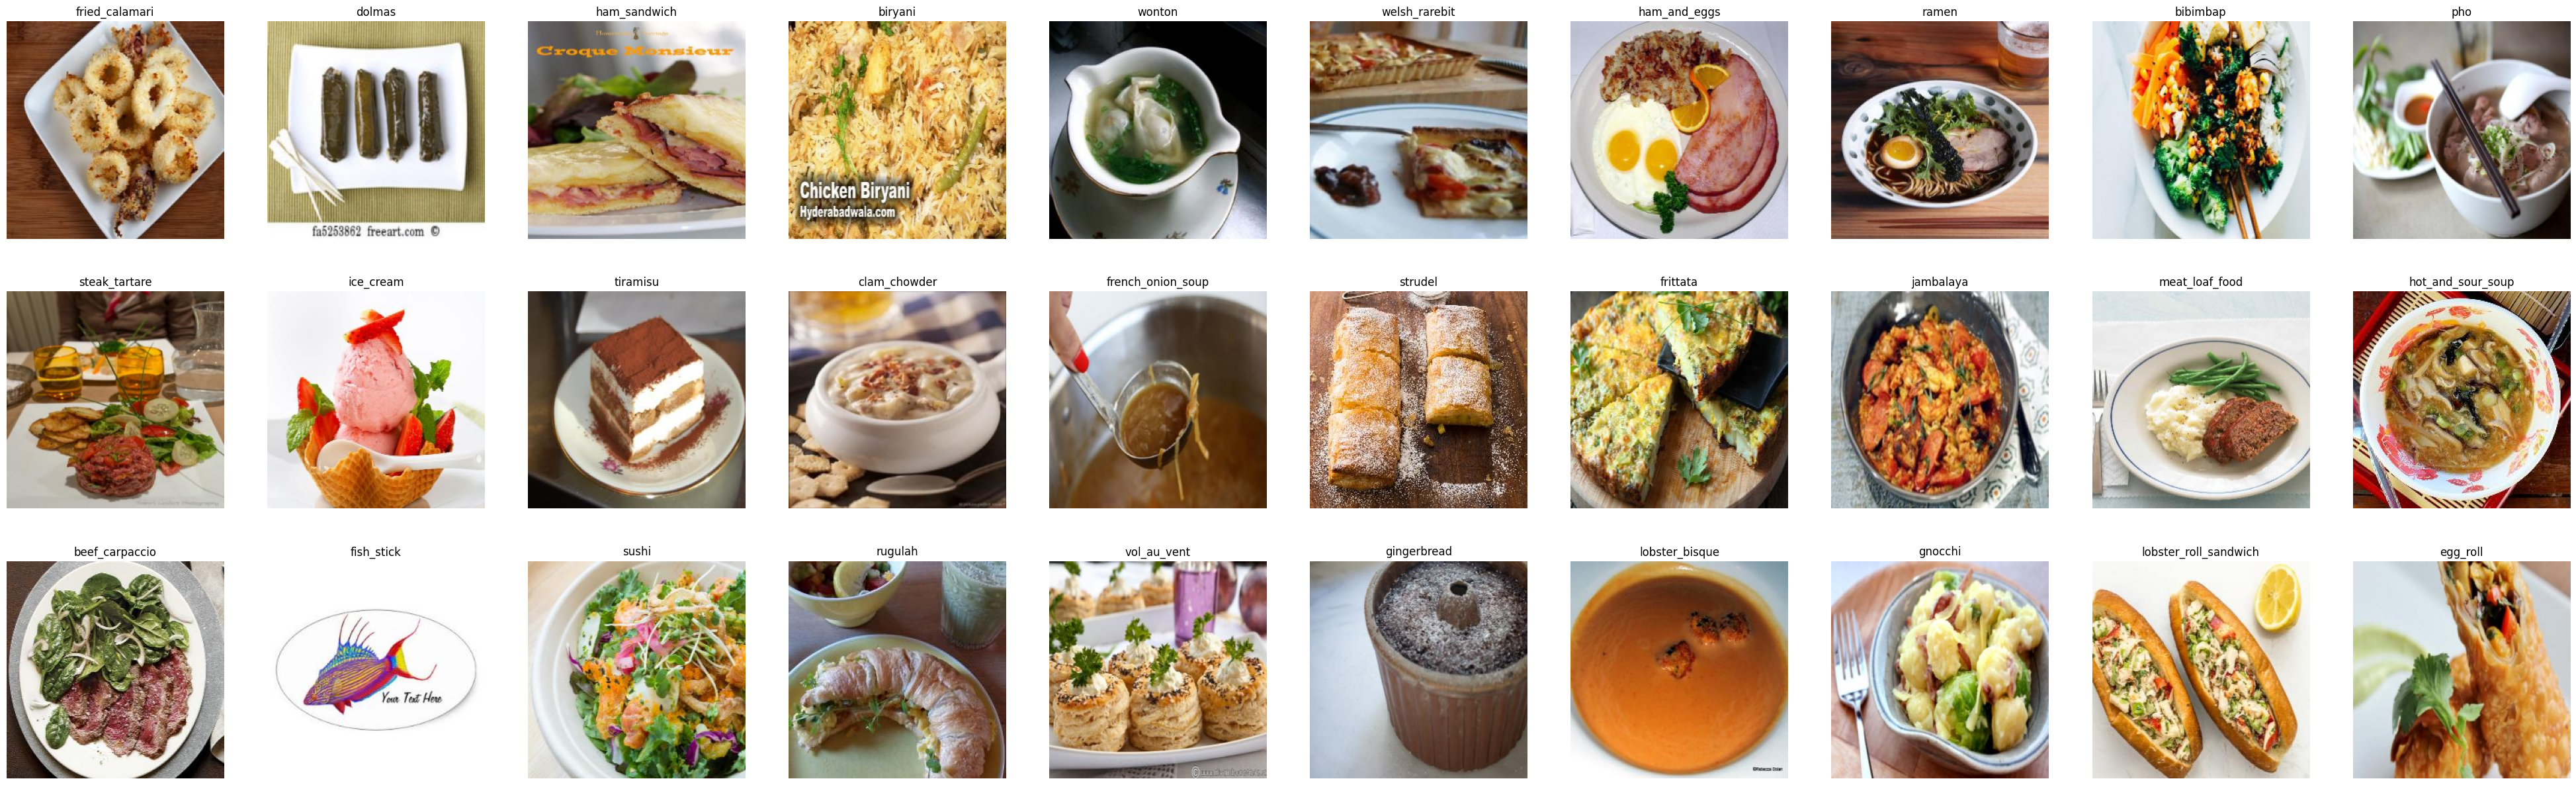

In [ ]:
#visualise some images as a sanity check
my_data.visualise_some_images(n=30)

## **2.2** - Traditional Classifiers

### 2.2.1 Data Preparation

In [ ]:
# use a custom datamodule for the traditional classification tasks in order to reduce computational complexity
data_urls = {
    "annotations": "https://food-x.s3.amazonaws.com/annot.tar",
    "training_images": "https://food-x.s3.amazonaws.com/train.tar",
    "validation_images": "https://food-x.s3.amazonaws.com/val.tar"
}

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Normalisation
])



my_data_traditional = MainDataModule(data_urls = data_urls, transform = transform, batch_size = 192)

In [ ]:
#download images
my_data_traditional.prepare_data_mine()

In [ ]:
#setup datasets
my_data_traditional.setup()

train shape: (94780,)
val shape: (23695,)
test shape: (11994,)


### 2.2.2 - feature extraction using sift and bag of words

In [ ]:
my_data_traditional.extract_sift_features()

mkdir: cannot create directory ‘train_features’: File exists
mkdir: cannot create directory ‘val_features’: File exists
mkdir: cannot create directory ‘test_features’: File exists
mkdir: cannot create directory ‘train_features/descriptors’: File exists
mkdir: cannot create directory ‘train_features/keypoints’: File exists
mkdir: cannot create directory ‘val_features/descriptors’: File exists
mkdir: cannot create directory ‘val_features/keypoints’: File exists
mkdir: cannot create directory ‘test_features/descriptors’: File exists
mkdir: cannot create directory ‘test_features/keypoints’: File exists


  0%|          | 0/94780 [00:00<?, ?it/s]

  0%|          | 0/23695 [00:00<?, ?it/s]

  0%|          | 0/11994 [00:00<?, ?it/s]

In [ ]:
my_data_traditional.setup_sift_datasets()

In [ ]:
my_data_traditional.extract_bow_features(vocabulary_size = 500)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/94780 [00:00<?, ?it/s]

anomaly at index 8001
anomaly at index 10680
anomaly at index 26288
anomaly at index 43910
anomaly at index 45278
anomaly at index 45539
anomaly at index 70934
anomaly at index 74498
anomaly at index 87993


  0%|          | 0/23695 [00:00<?, ?it/s]

anomaly at index 2400
anomaly at index 3784
anomaly at index 17174
anomaly at index 17244
anomaly at index 17335
anomaly at index 19318


  0%|          | 0/11994 [00:00<?, ?it/s]

In [ ]:
# vocabulary_size = 100
# bow_url = f"https://jig.blob.core.windows.net/jigcontainer/bow_features_{vocabulary_size}.tar"
# file_name = f"bow_features_{vocabulary_size}.tar"
# my_data.prepare_bow_features(bow_url = bow_url, file_name = file_name)

In [ ]:
my_data_traditional.setup_bow_features()

### 2.2.3 Model Training

In [ ]:
# function to train and validate models with a single run, prints the time taken too
def try_model(n_datapoints = 1000, vocabulary_size = 100, download = False,  model_class = None, data_module = None, model_params = None):

    if download:
        bow_url = f"https://jig.blob.core.windows.net/jigcontainer/bow_features_{vocabulary_size}.tar"
        file_name = f"bow_features_{vocabulary_size}.tar"
        my_data.prepare_bow_features(bow_url, file_name)
        my_data.setup_bow_features()



    start = time.time()

    X_train = data_module.train_bow[:n_datapoints,:vocabulary_size]
    y_train = data_module.train_labels[:config.n_datapoints]
    X_val =  data_module.val_bow[:n_datapoints,:vocabulary_size]
    y_val =  data_module.val_labels

    print(X_train.shape)

    model = model_class(**model_params)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
    precision = sklearn.metrics.precision_score(y_val, y_pred, average='micro')
    recall = sklearn.metrics.recall_score(y_val, y_pred, average='micro')
    f1 = sklearn.metrics.f1_score(y_val, y_pred, average='micro')

    end = time.time()

    print(f"time taken: {end - start}")

    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1: {f1}")


In [ ]:
# hashmap to handle hyperparameters sweeps
name_to_class = {
    "svm": sklearn.svm.SVC,
    "knn": sklearn.neighbors.KNeighborsClassifier,
    "rf": sklearn.ensemble.RandomForestClassifier,
    "ab": sklearn.ensemble.AdaBoostClassifier
}

In [ ]:
# Base function to train and validate a traditional model which can then be fit into a wandb sweeper
def train_and_eval_traditional(config = None, data_module = my_data_traditional):
    with wandb.init(config=config, project="supervised_learning_fp"):

        config = wandb.config

        #obtain the data
        X_train = data_module.train_bow
        y_train = data_module.train_labels
        X_val =  data_module.val_bow
        y_val =  data_module.val_labels

        #initialise the model
        model_params = {k: v for k, v in config.items() if k != 'model_name' and k!= 'n_datapoints'}
        model = name_to_class[config.model_name](**model_params)


        #train
        print("about to fit")
        model.fit(X_train,y_train)


        #compute predictions
        y_pred = model.predict(X_val)


        # Calculate evaluation metrics
        accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
        precision = sklearn.metrics.precision_score(y_val, y_pred, average='micro')
        recall = sklearn.metrics.recall_score(y_val, y_pred, average='micro')
        f1 = sklearn.metrics.f1_score(y_val, y_pred, average='micro')


        wandb.log({
            "val_acc": accuracy,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1
        })


2.2.1 - Support Vector Machines (SVMs)

In [ ]:
#get a sense of the time taken for a sweep run
try_model(
    n_datapoints = 94780,
    vocabulary_size = 500,
    download = False,
    model_class = sklearn.svm.SVC,
    data_module = my_data_traditional,
    model_params = {
        'C': 1,
        'kernel': 'rbf',
        'gamma': 'scale',
        'class_weight': 'balanced',
        'verbose': True
    }
)

(94780, 500)
[LibSVM]time taken: 4623.253307342529
accuracy: 0.010255328128297108
precision: 0.010255328128297108
recall: 0.010255328128297108
f1: 0.010255328128297108


In [ ]:
sweep_config = {
    'name': 'svm_sweep_5000_500',
    'method' : 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_datapoints' : {'value': 50000},
        'model_name': {'value': "svm"},
        'C': {'values': [0.01, 0.1, 1, 10, 100]},
        'kernel': {'value':  'rbf'},
        'gamma': {'value': 'scale'},
        'class_weight': {'value': 'balanced'},
        'verbose' : {'value': True}
    }

}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function = train_and_eval_traditional)


2.2.2 - k-Nearest Neighbors (k-NN)

In [ ]:
#get a sense of the time taken for a sweep run
try_model(
    n_datapoints = 94780,
    vocabulary_size = 500,
    download = False,
    model_class = sklearn.neighbors.KNeighborsClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_neighbors': 150,
        'weights': 'distance',
        'p': 2
    }
)

(94780, 500)
time taken: 79.5231020450592
accuracy: 0.004009284659210804
precision: 0.004009284659210804
recall: 0.004009284659210804
f1: 0.004009284659210804


In [ ]:

sweep_config = {
    'name': 'knn_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_datapoints' : {'value': 50000},
        'model_name': {'value': "knn"},
        'n_neighbors': {'values': [ 5, 10, 50, 100, 500, 1000]},
        'weights': {'values': ['uniform', 'distance']},
        'p': {'values' : [1, 2]}
    }
}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval_traditional)

2.2.3 - Naive Bayes

In [ ]:
#get a sense of the time taken for a sweep run
try_model(
    n_datapoints = 94780,
    vocabulary_size = 500,
    download = False,
    model_class = sklearn.naive_bayes.GaussianNB,
    data_module = my_data_traditional,
    model_params = {}
)

(94780, 500)
time taken: 13.490951776504517
accuracy: 0.008820426250263769
precision: 0.008820426250263769
recall: 0.008820426250263769
f1: 0.008820426250263769


2.2.4 - Random Forests

In [ ]:
#get a sense of the time taken for a sweep run
try_model(
    n_datapoints = 50000,
    vocabulary_size = 500,
    download = False,
    model_class = sklearn.ensemble.RandomForestClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_estimators': 500,
        'criterion': 'gini',
        'max_features': 0.1,
        'min_samples_leaf': 1
    }
)

(50000, 500)


In [ ]:
sweep_config = {
    'name': 'rf_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_datapoints' : {'value': 50000},
        'model_name': {'value': "rf"},
        'n_estimators': {'values': [50, 100]},
        'criterion': {'values': ['gini', 'entropy']},
        'max_depth' : {'value': 500}
    }
}



wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function = train_and_eval_traditional)

2.2.5 - Adaboost

In [ ]:
#get a sense of the time taken for a sweep run
try_model(
    n_datapoints = 50000,
    vocabulary_size = 500,
    download = False,
    model_class = sklearn.ensemble.AdaBoostClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_estimators': 10000,
        'learning_rate': 1
    }
)

(50000, 500)


In [ ]:
sweep_config = {
    'name': 'ab_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'n_datapoints' : {'value': 50000},
        'model_name': {'value': "ab"},
        'n_estimators': {'values': [10, 50, 100, 500, 1000, 5000]},
        'learning_rate': {'values': [1, 5]}
    }
}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function = train_and_eval_traditional)

## **2.3** - cnn

In order to experiment with a custom neural architecture I will start from a resnet model and explore some hyperparameter combinations. First, I will consider two types of residual blocks: normal and bottleneck. Then, I will consider different number of intermediate channels and pooling operation throughout the network. The number of intermediate channel and the number of pooling operations will be linked by the necessity to maintain ~500k parameters in the first linear layer.

In particular the governing equation will be $int\_channels = \frac{2^{2 n\_pools}}{2^3}$


In [ ]:
# obtain a sensible number of pools
n_pools_list = [4,5,6]

for n_pools in n_pools_list:
    int_channels = 2**(2*n_pools)/2**3
    dim = 128/(2**n_pools)
    tot_features = int_channels*dim*dim
    print(f"int_channels: {int_channels}, n_pools: {n_pools}, dim: {dim}, tot_features:{tot_features}")

int_channels: 8.0, n_pools: 3, dim: 16.0, tot_features:2048.0
int_channels: 32.0, n_pools: 4, dim: 8.0, tot_features:2048.0
int_channels: 128.0, n_pools: 5, dim: 4.0, tot_features:2048.0
int_channels: 512.0, n_pools: 6, dim: 2.0, tot_features:2048.0


In [ ]:
#base function to train and validate the neural network that then can be run through a sweeper
def train_and_eval(config = None, datamodule=my_data):
    with wandb.init(config=config):
        config = wandb.config

        #prepare data
        data_urls = {
            "annotations": "https://food-x.s3.amazonaws.com/annot.tar",
            "training_images": "https://food-x.s3.amazonaws.com/train.tar",
            "validation_images": "https://food-x.s3.amazonaws.com/val.tar"
        }

        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Normalisation
        ])

        my_data = MainDataModule(data_urls = data_urls, transform = transform, batch_size = config.batch_size)
        my_data.setup()


        #prepare model
        if config.net_type == "simple_cnn":
            model = SimpleCnn(n_classes = 251)
        elif config.net_type == "resnet":
            if config.block_type == "normal":
                n_blocks = 20
            elif config.block_type == "bottleneck":
                n_blocks = 30

            model = ResNet(in_channels = 3, int_channels = 32, n_blocks = n_blocks, n_pools = config.n_pools, block_type = config.block_type,  n_classes = 251)

        system = CnnImageClassification(
            model = model,
            loss_module = nn.CrossEntropyLoss(),
            optimizer_name = "Adam",
            optimizer_hparams = {"lr": config.learning_rate}
        )


        #prepare logger, callbacks, and trainer
        wandb_logger = L.pytorch.loggers.WandbLogger(project='supervised_learning_fp', job_type='train')

        checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            save_top_k=1,
            save_weights_only=False,
            verbose=True,
            dirpath=os.path.join(wandb.run.dir, "checkpoints"),
            filename="best_model",
        )

        early_stopping = L.pytorch.callbacks.EarlyStopping(
            monitor="val_acc",
            mode="max",
            patience=2,
            verbose=True
        )

        trainer = L.pytorch.Trainer(max_epochs=config.n_epochs,
            logger=wandb_logger,
            callbacks=[checkpoint_callback, early_stopping]
        )


        #fit the model
        trainer.fit(system, datamodule = my_data)

        #validate the model
        trainer.validate(system, datamodule = my_data)

        # Log the best model to WandB
        artifact = wandb.Artifact(f"best_{config.net_type}", type="model")
        artifact.add_file(checkpoint_callback.best_model_path)
        wandb.log_artifact(artifact)




In [ ]:
# hyperparameter sweer for fine tuning the simple cnn
sweep_config = {
    'name': 'simple_cnn_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {
            'value': 192
        },
        'net_type': {
            'value': "simple_cnn"
        },
        'activation': {
            'values' : ['relu', 'leaky_relu']
        },
        'n_epochs': {
            'value': 200
        },
        'learning_rate': {
            'values': [5e-5, 1e-4, 5e-4]
        }
    }

}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function=train_and_eval)


Create sweep with ID: gh2dpnsj
Sweep URL: https://wandb.ai/dan_mon_uni-uni/supervised_learning_fp/sweeps/gh2dpnsj


wandb: Agent Starting Run: 82d5izn2 with config:
wandb: 	large_ff: True
wandb: 	learning_rate: 0.0001
wandb: 	n_epochs: 200
wandb: 	net_type: simple_cnn


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_module'])`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:397: There i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc improved. New best score: 0.021
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_acc improved. New best score: 0.021
INFO: Epoch 0, global step 741: 'val_acc' reached 0.02136 (best 0.02136), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=0-step=741.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 741: 'val_acc' reached 0.02136 (best 0.02136), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=0-step=741.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.032
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.032
INFO: Epoch 1, global step 1482: 'val_acc' reached 0.03191 (best 0.03191), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=1-step=1482.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1482: 'val_acc' reached 0.03191 (best 0.03191), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=1-step=1482.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.040
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.040
INFO: Epoch 2, global step 2223: 'val_acc' reached 0.04039 (best 0.04039), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=2-step=2223.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 2223: 'val_acc' reached 0.04039 (best 0.04039), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=2-step=2223.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.050
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.050
INFO: Epoch 3, global step 2964: 'val_acc' reached 0.04980 (best 0.04980), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=3-step=2964.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 2964: 'val_acc' reached 0.04980 (best 0.04980), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=3-step=2964.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.057
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.057
INFO: Epoch 4, global step 3705: 'val_acc' reached 0.05727 (best 0.05727), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=4-step=3705.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 3705: 'val_acc' reached 0.05727 (best 0.05727), saving model to './supervised_learning_fp/82d5izn2/checkpoints/epoch=4-step=3705.ckpt' as top 1


In [ ]:
# hyperparameter sweep on the resnet architecture to experiment with architecture
sweep_config = {
    'name' : 'resnet_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {
            'value': 192
        },
        'net_type': {
            'values': ["resnet"]
        },
        'block_type': {
            'values': ["normal", "bottleneck"]
        },
        'n_pools': {
            'values': [3,4,5,6]
        },
        'n_epochs': {
            'value': 200
        },
        'learning_rate': {
            'value': 1e-4
        }
    }

}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function = train_and_eval)



In [ ]:
# final hyperparameter sweep to finetune the best resnet architecture
sweep_config = {
    'name' : 'resnet_sweep',
    'method': 'grid',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'batch_size': {
            'values': [64, 128, 192]
        },
        'net_type': {
            'values': ["resnet"]
        },
        'block_type': {
            'values': ["normal"]
        },
        'n_pools': {
            'values': [6]
        },
        'n_epochs': {
            'value': 200
        },
        'learning_rate': {
            'values': [5e-5, 1e-4, 5e-4, 1e-3]
        }
    }

}

wandb.login(key = 'a0a6c4e2d889c9df74d2c25801a218f7bc0b5c4a')
sweep_id = wandb.sweep(sweep_config, project="supervised_learning_fp")
wandb.agent(sweep_id, function = train_and_eval)



## **2.5** - model evaluation

### **2.5.1** - Traditional Models

In [ ]:
test_model(
    vocabulary_size = 100,
    download = False,
    model_class = sklearn.naive_bayes.GaussianNB,
    data_module = my_data_traditional,
    model_params = {}
)

In [ ]:
test_model(
    vocabulary_size = 100,
    download = False,
    model_class = sklearn.svm.SVC,
    data_module = my_data_traditional,
    model_params = {
        'C': 1,
        'kernel': 'rbf',
        'gamma': 'scale',
        'class_weight': 'balanced',
        'verbose': True
    }
)

In [ ]:
test_model(
    vocabulary_size = 100,
    download = False,
    model_class = sklearn.neighbors.KNeighborsClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_neighbors': 1000,
        'weights': 'uniform',
        'p': 2
    }
)

In [ ]:
test_model(
    vocabulary_size = 100,
    download = False,
    model_class = sklearn.ensemble.RandomForestClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_estimators': 100,
        'criterion': 'entropy',
        'max_depth': 50
    }
)

In [ ]:
test_model(
    vocabulary_size = 100,
    download = False,
    model_class = sklearn.ensemble.AdaBoostClassifier,
    data_module = my_data_traditional,
    model_params = {
        'n_estimators': 100,
        'learning_rate': 1
    }
)

### **2.5.2** - Deep Learning

In [25]:

# prepare the system by loading a checkpoint from the last sweep
sl_model = ResNet(in_channels = 3, int_channels = 32, n_blocks = 20, n_pools = 6, block_type = 'normal',  n_classes = 251)
sl_system = CnnImageClassification(
    model = sl_model,
    loss_module = nn.CrossEntropyLoss(),
    optimizer_name = "Adam",
    optimizer_hparams = {"lr": 1e-4}
)

checkpoint = torch.load('best_model.ckpt')

sl_system.load_state_dict(checkpoint['state_dict'])

sl_model = sl_system.model

#prepare data
data_urls = {
    "annotations": "https://food-x.s3.amazonaws.com/annot.tar",
    "training_images": "https://food-x.s3.amazonaws.com/train.tar",
    "validation_images": "https://food-x.s3.amazonaws.com/val.tar"
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # ImageNet Normalisation
])

my_data = MainDataModule(data_urls = data_urls, transform = transform, batch_size = 192)
my_data.prepare_data_mine()
my_data.setup()


# evaluate the model with the test set
trainer = L.pytorch.Trainer()
trainer.test(sl_system, datamodule = my_data)



<ipython-input-25-6cff0638f2bd>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.ckpt')


train shape: (94780,)
val shape: (23695,)
test shape: (11994,)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


train shape: (94780,)
val shape: (23695,)
test shape: (11994,)


Testing: |          | 0/? [00:00<?, ?it/s]

Test Accuracy: 0.2854
Test Precision: 0.3044
Test Recall: 0.2854
Test F1 Score: 0.2760


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.285392701625824     │
│      test_acc_batch       │     0.285392701625824     │
│          test_f1          │    0.27604979276657104    │
│      test_precision       │    0.30443182587623596    │
│        test_recall        │     0.285392701625824     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_batch': 0.285392701625824,
  'test_acc': 0.285392701625824,
  'test_precision': 0.30443182587623596,
  'test_recall': 0.285392701625824,
  'test_f1': 0.27604979276657104}]

#### model exploration

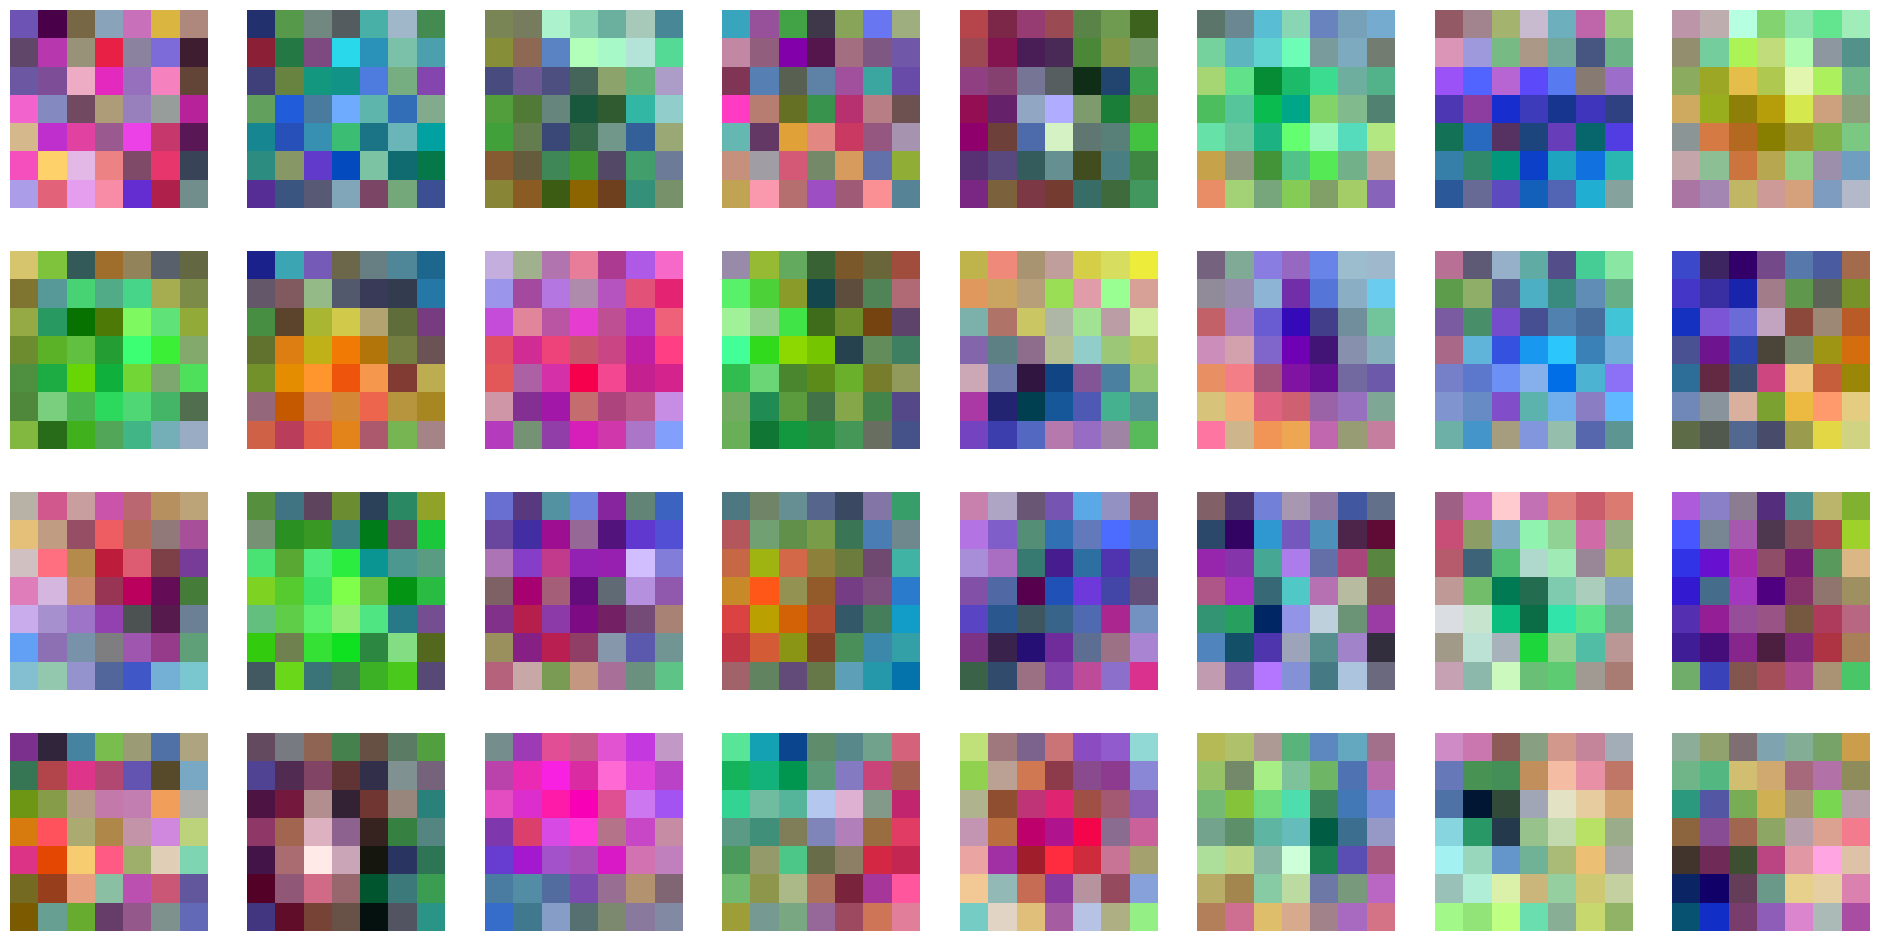

In [26]:
# visualisation of the first layer kernels
first_conv_layer = sl_model.funnel.conv

kernels = first_conv_layer.weight.data.cpu().numpy()

num_rows = 4
num_cols = int(kernels.shape[0]/num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))

for i in range(num_rows):
    for j in range(num_cols):

        filter_image = np.transpose(kernels[i*num_cols + j], (1, 2, 0))  # Move channels to the last dimension
        filter_image = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())

        axes[i,j].imshow(filter_image)
        axes[i,j].axis('off')  # Hide axis labels

plt.show()